# Assignment 1 344.063, Natural Language Processing with Deep Learning (NLPwDL) 2020S

* Markus Vogl, k01155575, vogl91@gmail.com
* Fathy Shalaby, k11701175, fathy.mshalaby@gmail.com


In [1]:
# RUN ONCE load models + data
#!python -m spacy download en_core_web_md
#import nltk
#nltk.download('stopwords')

# get data via wget if it doesn't exist
#!wget -nc http://öä.eu/sst5.data.txt
#!wget -nc http://öä.eu/sst5.labels.txt

# other option: load data via gdrive mounting
# drive.mount('/gdrive')
# %cd /gdrive/My Drive/sst5/<

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
import spacy 
import sklearn
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.base import TransformerMixin 
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD, PCA
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from spacy.lemmatizer import Lemmatizer
from spacy.tokens import Doc, Span, Token
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
flatten = lambda l: [item for sublist in l for item in sublist]
mapl =    lambda f, i: list(map(f, i))
filterl = lambda f, i: list(filter(f, i))
SEED = 42


**Data Exploration**

***sst-5 is a sentiment analysis collection, created based on the movie reviews in the IMDB
website [1]. The provided dataset in this assignment consists of a set of sentences, and their
corresponding labels. The labels are in 5 levels, annotated from very negative (-2) to very
positive (+2). The dataset is available for downloading in http://drive.jku.at/ssf/s/
readFile/share/14324/4544703232741430166/publicLink/sst5.zip***

In [3]:
df = pd.read_csv('sst5.data.txt')
X = np.array(df['text'])
Y = np.array(df['label'])
df

,sentence_id,text,label
0,0,Reno himself can take credit for most of the m...,1
1,1,"Despite the film 's shortcomings , the stories...",1
2,2,"Despite its dry wit and compassion , the film ...",-1
3,3,The central character is n't complex enough to...,0
4,4,Rifkin no doubt fancies himself something of a...,-2
...,...,...,...
11839,11839,"Just as moving , uplifting and funny as ever .",1
11840,11840,Davis ... is so enamored of her own creation t...,-1
11841,11841,"An exhilarating futuristic thriller-noir , Min...",2
11842,11842,I got a headache watching this meaningless dow...,-2


The data also has the issue, that the classes -1 and 1 have significantly more members: Over 6000 in these 2 vs 500 in the other 3 classes.

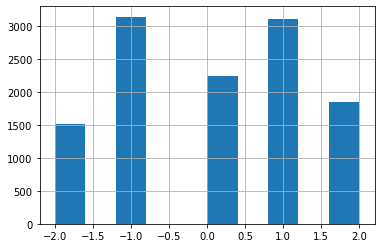

In [4]:
df['label'].hist()

In [5]:
labels = pd.read_csv('sst5.labels.txt',header=None)
label_id = {lab[0]: lab[1] for lab in labels.to_numpy()}; label_id

{-2: 'very negative',
 -1: 'negative',
 0: 'neutral',
 1: 'positive',
 2: 'very positive'}

**Manual data inspection for adjectives**


In [6]:
# loading a prebuilt the english language processing pipeline - that starts out with 3 components. this can take some time
nlp = spacy.load("en_core_web_md")
print(*nlp.pipeline, sep = "\n")

('tagger', <spacy.pipeline.pipes.Tagger object at 0x7fe8fe15fca0>)
('parser', <spacy.pipeline.pipes.DependencyParser object at 0x7fe8fe165880>)
('ner', <spacy.pipeline.pipes.EntityRecognizer object at 0x7fe8fe165dc0>)


In [7]:
# Loop to get just the adjectives from each review
docl = list( nlp.pipe(X)) # returns just an iterator -> make list
adj_filter = lambda tok: tok.pos_ == 'ADJ'
words_adj = [filterl(adj_filter, line) for line in docl]
df['words_adj'] = pd.Series(words_adj)
df.head() # we can see that for sentence 1 that adj were found which could be because of the default dictionary not having all words 
max_sent_len=max(len(docl[i]) for i in range(0,len(docl)))
print('maximum sentence length = ', max_sent_len)

maximum sentence length =  56


Analyze the most common adjectives and plot histograms

4               [honest, entire, crude, exploitative]
16                                             [lead]
36                      [own, sadistic, sour, little]
37                                                 []
41       [loose, unaccountable, sophisticated, worst]
                             ...                     
11797                            [elemental, genuine]
11800                                [slapstick, big]
11806                          [first, second, small]
11821                        [small, natural, pretty]
11842                                   [meaningless]
Name: words_adj, Length: 1508, dtype: object
very negative [('bad', 147), ('good', 46), ('dull', 41), ('more', 38), ('much', 29), ('own', 28), ('old', 28), ('little', 27), ('funny', 27), ('many', 25)]
2                        [dry, philosophical, sedate]
13               [cold, intricate, difficult, deeper]
17                                                 []
22                                         

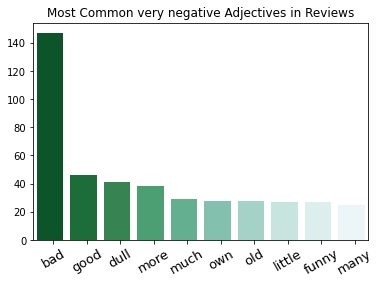

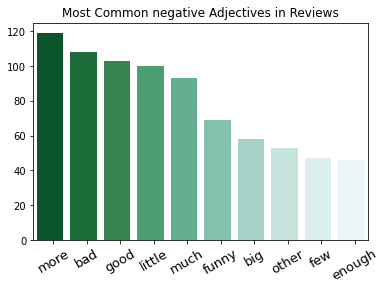

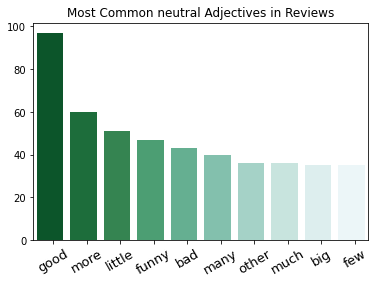

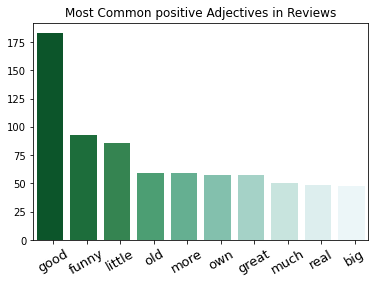

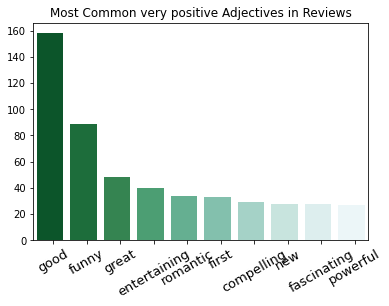

In [8]:
# Print the most common adjectives
adj_count = dict()
for id in label_id:
    adj = df[df['label']==id]['words_adj']
    print(adj)
    adj = flatten(adj)
    adj = mapl(lambda tok: tok.lemma_, adj)
    adj_count[id] = Counter(adj).most_common(10)
    print(label_id[id],adj_count[id])

#Potting of all review types
def plot_reviews(adj_count,reviewtype):
    labels, values = zip(*adj_count)
    indexes = np.arange(len(labels))

    #sns.set(style="whitegrid")
    ax = sns.barplot(indexes, values, palette="BuGn_r")

    plt.xticks(indexes + 0.1, labels, rotation=30);
    plt.tick_params(axis='x', labelsize=13)
    plt.title("Most Common "+str(reviewtype)+" Adjectives in Reviews")
    plt.show()


for id in label_id:
    plot_reviews(adj_count[id],label_id[id])

## Task1: Dataset Preparation

If you want class-balancing for task 4.3, rerun this notebook with this cell enabled

### Preprocessing. 
***Apply cleaning, preprocessing, and tokenization to the text. Describe and justify the methods you used for each of these, and provide some examples.***

Most of this is done by the en_core_web_sm piepline, that contains an english tokenizer, a tagger that cleans up unneccesary spaces, a parser and a named entity recognizer and has built in stopword detection.

But we can improve it by adding NLTK stemming and building a custom dict.

Stopwords - can be checked with tok.is_stop()

In [9]:
# use spacy and nltk stopwords and put them into the default nlp stopword detector
print("Adding nltk stopwords", set(nltk.corpus.stopwords.words('english')).difference(nlp.Defaults.stop_words))
nlp.Defaults.stop_words = nlp.Defaults.stop_words.union(nltk.corpus.stopwords.words('english')); 
print("Total list of stopwords", ", ".join(sorted(nlp.Defaults.stop_words)))

Adding nltk stopwords {'having', 'aren', 'isn', 'wouldn', 'mustn', "mustn't", 'didn', 've', 'mightn', 'y', 'hadn', "she's", "hadn't", 'needn', 'don', "don't", "won't", 'wasn', "wouldn't", "mightn't", "haven't", "wasn't", "didn't", 'couldn', 'shouldn', "needn't", 'hasn', 'ma', "weren't", "couldn't", 'doesn', 'ain', 't', 'won', 'd', "you're", 'm', "you'd", "that'll", "doesn't", 's', "shouldn't", "aren't", 'weren', "isn't", "it's", "should've", 'shan', "shan't", "hasn't", 'theirs', "you've", 'll', "you'll", 'haven', 'o'}
Total list of stopwords 'd, 'll, 'm, 're, 's, 've, a, about, above, across, after, afterwards, again, against, ain, all, almost, alone, along, already, also, although, always, am, among, amongst, amount, an, and, another, any, anyhow, anyone, anything, anyway, anywhere, are, aren, aren't, around, as, at, back, be, became, because, become, becomes, becoming, been, before, beforehand, behind, being, below, beside, besides, between, beyond, both, bottom, but, by, ca, call, c

To add a custom stemmer, you can extend tokens with getters

In [10]:
stem_function = PorterStemmer().stem
Token.set_extension("stem", getter=lambda tok: stem_function(tok.lemma_), force=True) # force=True to be able to rerun the line 

Print 3 sentences with to show lemmatization, stemming, stopwords and more:

In [11]:
print("Word\tLemma\tStem\tstop")
for d in docl[:3]:
    for word in d:
        print(word, word.lemma_, word._.stem, word.is_stop or word.is_punct, sep="\t")
    print() # newline between sentences

Word	Lemma	Stem	stop
Reno	Reno	reno	False
himself	-PRON-	-pron-	True
can	can	can	True
take	take	take	True
credit	credit	credit	False
for	for	for	True
most	most	most	True
of	of	of	True
the	the	the	True
movie	movie	movi	False
's	's	's	True
success	success	success	False
.	.	.	True

Despite	despite	despit	False
the	the	the	True
film	film	film	False
's	's	's	True
shortcomings	shortcoming	shortcom	False
,	,	,	True
the	the	the	True
stories	story	stori	False
are	be	be	True
quietly	quietly	quietli	False
moving	move	move	False
.	.	.	True

Despite	despite	despit	False
its	-PRON-	-pron-	True
dry	dry	dri	False
wit	wit	wit	False
and	and	and	True
compassion	compassion	compass	False
,	,	,	True
the	the	the	True
film	film	film	False
suffers	suffer	suffer	False
from	from	from	True
a	a	a	True
philosophical	philosophical	philosoph	False
emptiness	emptiness	empti	False
and	and	and	True
maddeningly	maddeningly	maddeningli	False
sedate	sedate	sedat	False
pacing	pacing	pace	False
.	.	.	True



### Creating a dictionary.
***Using all the texts of the dataset, create a dictionary of vocabularies. Explain your criteria for building the dictionary such as the method to reduce the vocabulary size. Report the statistics of the dictionary.***

To reduce the dict size we use lemmatization and stopword/punctuation removal. This leads to 250k -> 15k -> 12k vocabulary size.

In [12]:
vocab0 = set(flatten(docl))
print("Size without any filtering/stemming", len(vocab0))
print("Examples", list(vocab0)[:50])

vocab1 = set(flatten([map(lambda tok: tok.lemma_, line) for line in docl]))
print("Size with lemmatization alone", len(vocab1))
print("Examples", list(vocab1)[:50])

stemf = lambda tok: tok._.stem
tokfilt = lambda tok: not tok.is_stop and not tok.is_punct

stem_doc = [ mapl(stemf, # only use stem
                  filter(tokfilt, line)) # filter out punctuation
             for line in docl]
vocab2 = set(flatten(stem_doc)) # make unique set out of list of list
print("Size with filtering/stemming", len(vocab2))
print("Examples", list(vocab2)[:50])

Size without any filtering/stemming 235066
Examples [running, brutally, `, 're, ,, too, it, ideas, Francophiles, This, -, Nature, like, there, quite, Nothing, ,, like, big, Gloriously, incurably, or, ,, Fire, of, several, its, best, Weaver, in, worst, conditioning, and, A, intimate, pounds, is, dialogue, should, and, observe, of, are, the, it, love, n't, this, the, around]
Size with lemmatization alone 15800
Examples ['spectrum', 'dogged', 'Original', 'discouraging', 'scenario', 'pedestal', 'Collosum', 'litmus', 'simultaneously', 'Tolstoy', 'blisteringly', 'substantive', 'sampling', 'coast', 'just', 'efficient', 'wither', 'have', 'unease', 'dive', 'humourless', 'exhibit', 'clamor', 'labour', 'sure', 'southern', 'Dolby', 'focused', 'trumpet', 'nrelentingly', 'Cox', 'age', 'ferocious', 'pasta', 'delicately', 'contemptuous', 'Neil', 'backmasking', 'exit', 'Le', 'Orleans', 'monster\\/science', 'extraordinarily', 'forth', 'sized', 'conspicuously', 'relocate', 'Saldanha', 'courage', 'meld']


### Splitting the dataset. 
***Divide the dataset to train, validation, and test sets. Explain your method for splitting and report the size of each set.***

In [13]:
text_train, text_test, label_train, label_test = train_test_split(docl,Y,test_size = 0.2,random_state = SEED)
print(*zip(label_train[:10], text_train[:10]), sep="\n")

(-1, Care deftly captures the wonder and menace of growing up , but he never really embraces the joy of Fuhrman 's destructive escapism or the grace-in-rebellion found by his characters .)
(0, ... Ice Age treads predictably along familiar territory , making it a passable family film that wo n't win many fans over the age of 12 .)
(-1, Oft-described as the antidote to American Pie-type sex comedies , it actually has a bundle in common with them , as the film diffuses every opportunity for a breakthrough)
(-2, Some writer dude , I think his name was , uh , Michael Zaidan , was supposed to have like written the screenplay or something , but , dude , the only thing that I ever saw that was written down were the zeroes on my paycheck .)
(1, It has plenty of laughs .)
(1, Grant carries the day with impeccable comic timing , raffish charm and piercing intellect .)
(-1, When the fire burns out , we 've only come face-to-face with a couple dragons and that 's where the film ultimately fails .)


## Task2: Feature Extraction

### Creating sentence vectors. 
***Creating sentence vectors. Given the dictionary, prepare two variations of the representation vectors for each sentence. Each variation should be based on a term weighting method. Report the applied approaches. What percentage of the vectors of all the sentences are filled with zero values (sparsity rate)?***

We are using [TF-IDF (Term-Frequency, Inverse-Document-Frequency)](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) appraoch which includes the term and document frequencies for term weighting. 

Our 2nd approach is the spacy builtin [word2vec](https://en.wikipedia.org/wiki/Word2vec) which only has implicit pretrained weighting. 


**word-ids**

In [14]:
sec2vec = {word:i for i,word in enumerate(vocab0)}

### TF-idf with scikit learn

In [15]:
# as our data is already tokenized, we can skip tokenization by setting the tokenizer to the identity function and skipping lowercase
tfvectorizer = TfidfVectorizer(vocabulary=vocab2, tokenizer=lambda x: x, lowercase=False);
tfdoc = tfvectorizer.fit_transform(stem_doc)
print(tfvectorizer); tfdoc

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=False, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function <lambda> at 0x7fe8e1743940>, use_idf=True,
                vocabulary={'$', '+', '-pron-', '007', '1', '1.2', '1.8', '10',
                            '10,000', '10-cours', '10-inch', '10-year', '100',
                            '100-minut', '100-year', '101', '102-minut',
                            '103-minut', '104', '105', '10th', '11', '11-year',
                            '110', '112-minut', '117', '11th', '12', '12-step',
                            '12-year', ...})


<11844x12060 sparse matrix of type '<class 'numpy.float64'>'
	with 101222 stored elements in Compressed Sparse Row format>

In [16]:
print("The sparcity rate (rate of emtpy elements) is", 100*(1 - len(tfdoc.nonzero()[0])/np.prod(tfdoc.shape)), "%")

The sparcity rate (rate of emtpy elements) is 99.9291354216198 %


As this array is 11844x12081, you can't use PCA which is why we can only use TruncatedSVD

### Word2Vec with spacy
Spacy also offers a built in word2vec in all models bigger than small, and word2vec is the state of the art for text vectorization. The vec size is 96


In [17]:
w2v = np.array(mapl(lambda tok: tok.vector, docl)); w2v.shape

(11844, 300)

### Dimensionality reduction. 
***Apply a dimensionality reduction algorithm to the sentence vectors to reduce their size to k dimensions.***


In [18]:
tf_20 = TruncatedSVD(n_components=20).fit_transform(tfdoc)
w2v_20 = PCA(n_components=20).fit_transform(w2v)

## Task3: Classification

### Training classifiers. 
***Select at least three classification algorithms to create machine learning models. Using either of the variations of the sentence vectors, train a classification model for each classification algorithm. This should result in six classification models (two variations of sentence vectors × three classification algorithms). For each model, consider at least five different sets of hyper-parameters’ values. These hyper-parameters include the ones of the classifier, but also the dimensionality size k. Tune these hyper-parameters during the training of each model. Report the process of hyper-parameter tuning, and the selected hyper-parameters’ values for each model. Evaluate the models using the accuracy metric***

In [19]:
def train(clf,x_train,y_train,hyperparameter):
    """
    clf: The specified model
    x_train:The sentence vector from the training dataset
    y_train:The corresponding labels from the training dataset
    hyperparameter:Dictionary with parameters names (string) as keys and lists of parameter settings to try as values.
    """
    classifier = GridSearchCV(clf, hyperparameter,n_jobs=8,cv=10)
    grid_result = classifier.fit(x_train,y_train)
    print('Score: ',grid_result.best_score_)
    return grid_result.best_estimator_

In [20]:
print('Baseline = ',max(list(Counter(Y).values()))/sum(list(Counter(Y).values())))

Baseline =  0.2648598446470787


**Classifers**

In [21]:
names = ['Gradient boosting','Random Forest','Linear Support vector','SGD Classifier']
model_list = [GradientBoostingClassifier(),RandomForestClassifier(),LinearSVC(),SGDClassifier()]
hyperparameters = [{'learning_rate':[0.1,0.01,0.001]}, 
                   {'n_estimators':[100,1000],'random_state':[42],'class_weight':("balanced",None)},
                   {'loss':('hinge','squared_hinge'),'C':[1.0,8.0,10.0],'random_state':[42]},
                   {'loss':('hinge','squared_epsilon_insensitive'),'epsilon':[0.1,0.25,0.01]}]

### Results and comparison. 
Report the evaluation results of the models on both validation and test sets in a table. Compare different models, and conclude the best performing approach on the dataset.

In [22]:
def scores(clf, X_val, y_val,X_test,y_test):
    """
    Input:
        clf: The model
        X_val:The sentence vector from the validation dataset
        y_val: The corresponding labels from the validation dataset
        X_test:The sentence vector from the test dataset
        y_test:The corresponding labels from the test dataset
    Output:
        acc_val: Accuracy for the validation set
        acc_test: Accuracy for the test set 
        conf_mat: Confusion matrix for the validation set
        conf_mat_test: confusion matrix for the test set 
    """
    confidence = clf.score(X_val,y_val)
    y_pred = clf.predict(X_val)
    acc_val = accuracy_score(y_val, y_pred)
    conf_mat = confusion_matrix(y_val, y_pred)
    test_labels_pred = clf.predict(X_test)
    acc_test = accuracy_score(y_test, test_labels_pred)
    conf_mat_test = confusion_matrix(y_test, test_labels_pred)
    return acc_val,acc_test,conf_mat,conf_mat_test

def evaluate(model_list,vectors,hyperparameters,names):
    """
    Input:
        model_list: A list which contains all initilized models
        vectors: A dictionary which contains the name of the sentence vector as keys and sentence vector variable as a value
        hyperparameters: A list of dictionaries that contain the parameters for each model 
        names: A list containg the names of the models as strings
    Output:
        table: pandas dataframe which displays the classifers the corrresp[onding sentence vectors and how they performed
        conf_list: A list which contains the corresponding confusion matrix for each classifier
    """
    test_acc_list = []
    val_acc_list=[]
    sentence_vector_list = []
    conf_list = []
    name_list = []
    for key in vectors.keys():
        i=0
        print('Sentence Vector',key)
        x_train,x_test,y_train,y_test = train_test_split(vectors[key],Y,test_size=.2,random_state=42)
        x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=.2,random_state=42)
        for model in model_list:
            print('classifier = ',names[i])
            clf = train(model,x_train,y_train,hyperparameters[i])
            #print('finished training')
            val_acc,test_acc,conf_val,conf_test= scores(clf,x_val,y_val,x_test,y_test)
            test_acc_list.append(test_acc)
            val_acc_list.append(val_acc)
            sentence_vector_list.append(key)
            name_list.append(names[i])
            conf_list.append((conf_val,conf_test))
            i+=1
    table = pd.DataFrame({'Model':model_list+model_list,
                    'sentence vector':sentence_vector_list,
                    'Validation Accuracy ':val_acc_list,
                    'Test Accuracy':test_acc_list})

    return table, conf_list

vectors = {'tf-id':tf_20,'word2vec':w2v_20}
result, conf_list= evaluate(model_list,vectors,hyperparameters,names)
result

Sentence Vector tf-id
classifier =  Gradient boosting
Score:  0.33047493403693934
finished training
classifier =  Random Forest


/usr/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Score:  0.3092348284960423
finished training
classifier =  Linear Support vector
Score:  0.31965699208443277
finished training
classifier =  SGD Classifier
Score:  0.3006596306068602
finished training
Sentence Vector word2vec
classifier =  Gradient boosting
Score:  0.3804749340369393
finished training
classifier =  Random Forest


/usr/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Score:  0.3889182058047493
finished training
classifier =  Linear Support vector


/usr/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Score:  0.40382585751978894
finished training
classifier =  SGD Classifier
Score:  0.3606860158311346
finished training


,Model,sentence vector,Validation Accuracy,Test Accuracy
0,"GradientBoostingClassifier(ccp_alpha=0.0, crit...",tf-id,0.342480,0.325454
1,"RandomForestClassifier(bootstrap=True, ccp_alp...",tf-id,0.315567,0.316167
2,"LinearSVC(C=1.0, class_weight=None, dual=True,...",tf-id,0.327704,0.301393
3,"SGDClassifier(alpha=0.0001, average=False, cla...",tf-id,0.305541,0.305192
4,"GradientBoostingClassifier(ccp_alpha=0.0, crit...",word2vec,0.400528,0.373997
5,"RandomForestClassifier(bootstrap=True, ccp_alp...",word2vec,0.407388,0.377374
6,"LinearSVC(C=1.0, class_weight=None, dual=True,...",word2vec,0.418997,0.400169
7,"SGDClassifier(alpha=0.0001, average=False, cla...",word2vec,0.387863,0.368510


8


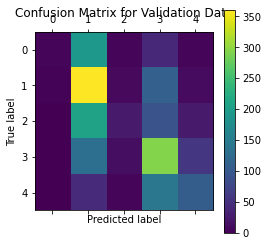

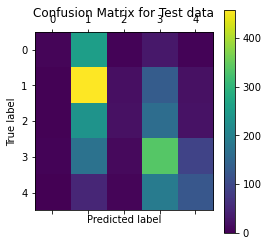

In [23]:
def plot_confusion_matrix(num_classifer,conf_list):
    """
    Input:
        num_classifer: The classifer which we want to see the confusion matrix of
        conf_list: A list of confusion matrices corresponding to each classifier in the table above
    Output:
        Two confusion matrix plots of both the validation dataset and the test dataset 
    """
    conf_mat, conf_mat_test = conf_list[num_classifer]
    for name, data in [("Validation Data", conf_mat), ("Test data", conf_mat_test)]:
        # Plot Confusion Matrix Data as a Matrix
        plt.matshow(data)
        plt.title('Confusion Matrix for '+name)
        plt.colorbar()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()
print(len(conf_list))
plot_confusion_matrix(6,conf_list) # Plots the confusion matrix of the best model based on the test accuracy score shown above

### Summary Findings: Explanation of behaviour
Looking at the matrix above and the results table in the Results and comparison section, we can see that the accuracy scores that we got when evaluating the model are due to our model focusing on two classes mainly out of the 5 classes in this dataset. We can see that our model predicts the best on class 1(negative) and class 3 (positive) best. This performance can be due to many factors that include the data distribution and the vocabulary in the specific classes. As shown during our Data exploration section of our notebook there are many overlapping words between the classes which further contributed to the accuracy score that we got for this task. Furthermore we can also see that the model somewhat performs well on class 4 also (very positive) which again could be due to the overlap in features between the classes.  The model doesnt perform so well in predicting coirrectly for the class 0 and 2 which are very negative and neutral respectively, which could be due to the vocab in these classes doesn't occur enough in the samples or they include characteristucs like sarcasm which is not easy to detect.

## **Task4 (optional): Visualization and Analysis**

***Feel free to follow any idea/question that provides more insights on experiments. For instance,
what is the effect of various components, namely preprocessing methods, dimensionality reduction,
and classification algorithms, on the effectiveness of the classifier? Provide visualizations of the
sentence representations, and compare the plots of the representations with the predicted versus
correct labels.***

### Questions
We want to find out two things about our preprocessing:
1. Does the stemming + lemmatization preprocessing (used with TF-IDF) actually help?
2. Does applying PCA to to our word2vec help?
3. Would balacing the classes help?

In [24]:
#tF_idf + random forest, trying some other preprocessing like the none-preprocessing
tfvectorizer = TfidfVectorizer(vocabulary=vocab0, tokenizer=lambda x: x, lowercase=False)
tfdoc = tfvectorizer.fit_transform(stem_doc)
tf_20 = TruncatedSVD(n_components=20).fit_transform(tfdoc)

# word2vec, if it performs differently if we don't PCA it in between
names = ['Gradient boosting','Random Forest','Linear Support vector','SGD Classifier']
model_list = [GradientBoostingClassifier(),RandomForestClassifier(),LinearSVC(),SGDClassifier()]
hyperparameters = [{'learning_rate':[0.1,0.01,0.001]},
                   {'n_estimators':[100,1000],'random_state':[42],'class_weight':("balanced",None)},
                   {'loss':('hinge','squared_hinge'),'C':[1.0,8.0,10.0],'random_state':[42]},
                   {'loss':('hinge','squared_epsilon_insensitive'),'epsilon':[0.1,0.25,0.01]}]

vectors = {'tf-id':tf_20,'word2vec':w2v}
result,conf_list= evaluate(model_list,vectors,hyperparameters,names); result

/usr/lib/python3.8/site-packages/sklearn/decomposition/_truncated_svd.py:194: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Sentence Vector tf-id
classifier =  Gradient boosting
Score:  0.26503957783641163
finished training
classifier =  Random Forest
Score:  0.26503957783641163
finished training
classifier =  Linear Support vector
Score:  0.26503957783641163
finished training
classifier =  SGD Classifier
Score:  0.25620052770448554
finished training
Sentence Vector word2vec
classifier =  Gradient boosting
Score:  0.40633245382585753
finished training
classifier =  Random Forest


/usr/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Score:  0.4050131926121372
finished training
classifier =  Linear Support vector
Score:  0.4183377308707124
finished training
classifier =  SGD Classifier
Score:  0.3981530343007916
finished training


,Model,sentence vector,Validation Accuracy,Test Accuracy
0,"GradientBoostingClassifier(ccp_alpha=0.0, crit...",tf-id,0.261741,0.266779
1,"RandomForestClassifier(bootstrap=True, ccp_alp...",tf-id,0.261741,0.266779
2,"LinearSVC(C=1.0, class_weight=None, dual=True,...",tf-id,0.261741,0.266779
3,"SGDClassifier(alpha=0.0001, average=False, cla...",tf-id,0.261741,0.261714
4,"GradientBoostingClassifier(ccp_alpha=0.0, crit...",word2vec,0.424274,0.406079
5,"RandomForestClassifier(bootstrap=True, ccp_alp...",word2vec,0.420053,0.416631
6,"LinearSVC(C=1.0, class_weight=None, dual=True,...",word2vec,0.419525,0.414099
7,"SGDClassifier(alpha=0.0001, average=False, cla...",word2vec,0.387335,0.377797


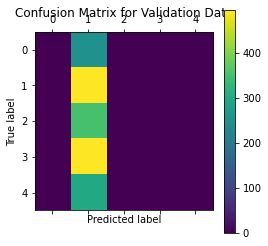

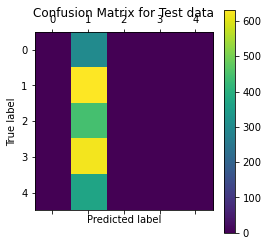

In [25]:
plot_confusion_matrix(1,conf_list) #confusion matrix for Random Forest + TF-ID

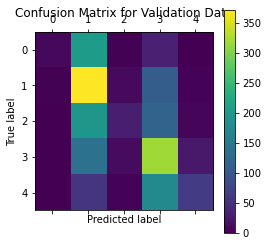

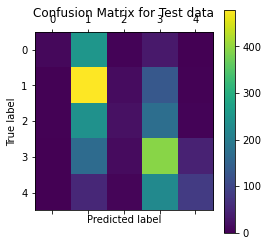

In [26]:
plot_confusion_matrix(5,conf_list) #confusion matrix for best model

### Results for balanced classes

When rerunning the notebook with the 1st cell in preprocessing enabled for ballanced classes, we get the following results (included as a screenshot image):

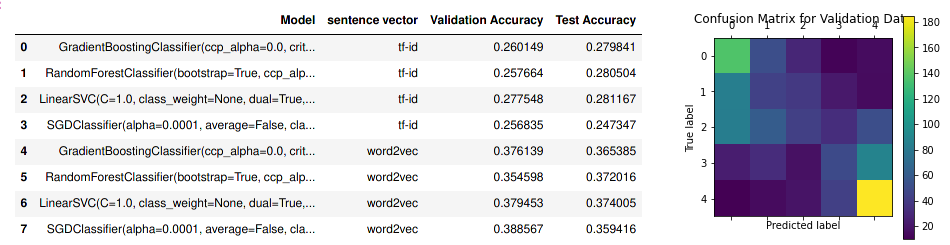

The confusion-matrices for all the classifiers would look roughly the same and just like in the non-normalized case, the validation-testset looks roughly the same and performs ~2-3% worse.

However, this is to a 20% baseline, so on this limited subsample of data, it performs slightly better on the sub-sampled data, but now strongly over-predicts the -2 and +2 classes, as they are easier to separate.

If we use the classifier on the unbalanced data (rerun cell for realoading the original data + rerun validation), it would still over-predict the rather small -2 and +2 classes. This would lead to a sub-26%-baseline result.

### Summary Findings
1. the TF-IDF accuracies are significantly worse: Roughly 26% without preprocessing vs 27-35% with preprocessing.
2. using raw word2vec without PCA yields 42% instead of 40% (with vectors of dimensionality 300 vs 20 PCA) - while increasing computation times 5-fold (as there is more data)
3. rerunning the notebook with enabling the balancing-cell would not lead to slightly better performing classes - the over-prediction of the bigger classes is a natural consequence of the data.

But the principle problems of classifiers over-predicting into the classes -1 and 1 gets even worse here, our tf-idf only predicted the majority-class -1.